In [ ]:
!pip install keras
!pip install wrapt
!pip install tensorflow
!pip install tmu
!pip install opencv-python

In [2]:
import numpy as np
import cv2

import matplotlib.pyplot as plt
from keras.datasets import cifar10

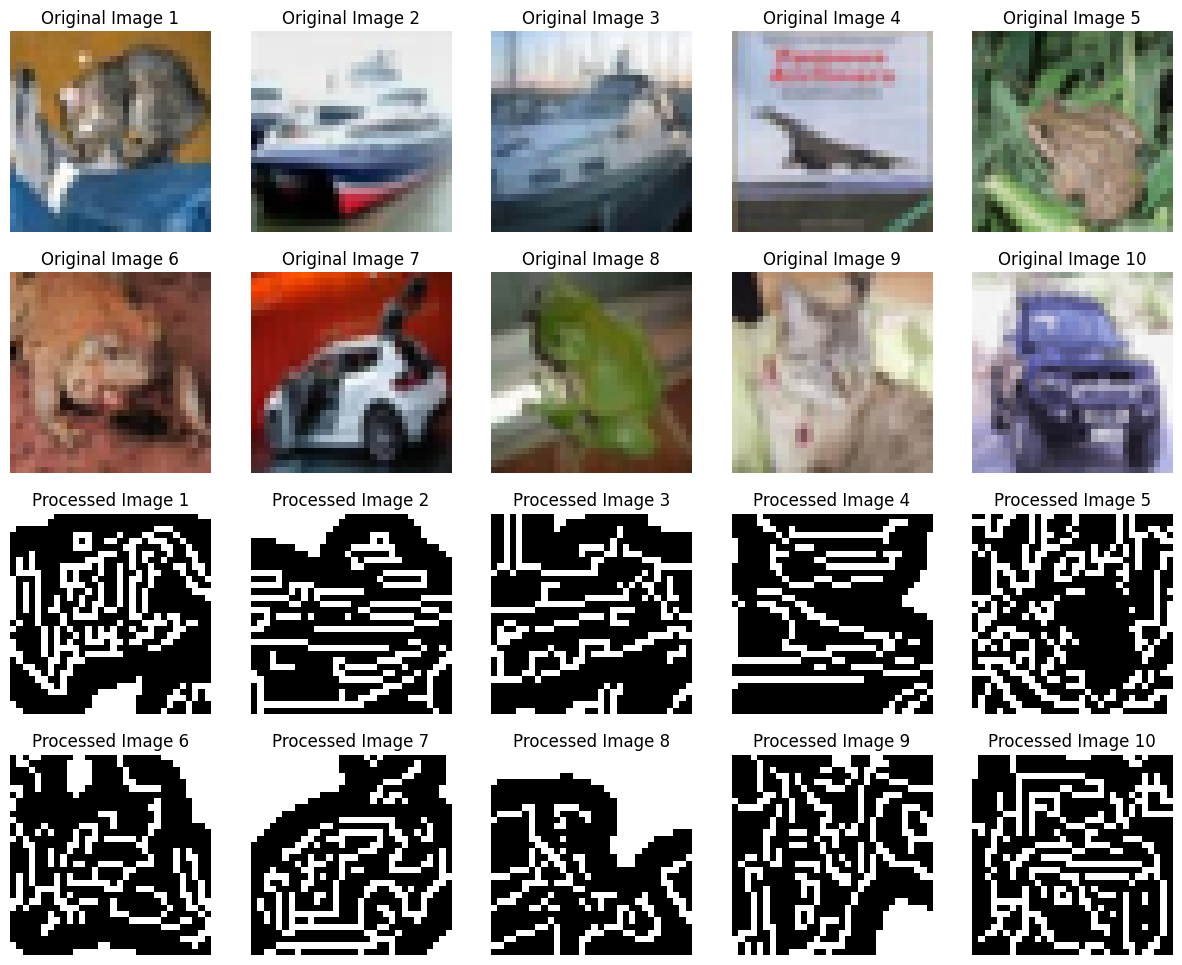

In [5]:
import cv2
from matplotlib import pyplot as plt
from keras.datasets import cifar10

# Load CIFAR-10 dataset
(X_train_org, Y_train_org), (X_test_org, Y_test_org) = cifar10.load_data()

X_train = np.copy(X_train_org)
X_test = np.copy(X_test_org)

Y_train=Y_train_org.reshape(Y_train_org.shape[0])
Y_test=Y_test_org.reshape(Y_test_org.shape[0])

# Function to preprocess images using Canny edge detection
def preprocess_images(images):
    processed_images = []
    for image in images:

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply Canny edge detection
        edges = cv2.Canny(gray, 100, 200)

        # Apply Hough Transform to detect lines
        lines = cv2.HoughLines(edges, 1, np.pi/180, 200)

        # Draw the lines on the image
        if lines is not None:
            for line in lines:
                rho, theta = line[0]
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a * rho
                y0 = b * rho
                x1 = int(x0 + 1000 * (-b))
                y1 = int(y0 + 1000 * (a))
                x2 = int(x0 - 1000 * (-b))
                y2 = int(y0 - 1000 * (a))
                cv2.line(edges, (x1, y1), (x2, y2), (0, 0, 255), 2)

        image = cv2.adaptiveThreshold(edges, 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
        
        processed_images.append(image)
    return np.array(processed_images)

X_train_processed = preprocess_images(X_train)
X_test_processed = preprocess_images(X_test)

# Display the images
plt.figure(figsize=(15, 12))

for i in range(10):
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_test[i])
    plt.title('Original Image {}'.format(i + 1))
    plt.axis('off')

    plt.subplot(4, 5, i + 11)
    plt.imshow(X_test_processed[i], cmap='gray')
    plt.title('Processed Image {}'.format(i + 1))
    plt.axis('off')

plt.savefig('canny.png')
plt.show()

In [10]:
print(X_train.shape)
print(X_train_processed.shape)

#X_train = X_train_processed
#X_test = X_test_processed

(50000, 32, 32, 3)
(50000, 32, 32)


In [16]:
for i in range(X_train.shape[0]):
    for j in range(X_train.shape[3]):
        X_train[i,:,:,j] = cv2.adaptiveThreshold(X_train_processed[i,:,:,j], 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
            
for i in range(X_test.shape[0]):
    for j in range(X_test.shape[3]):
        X_test[i,:,:,j] = cv2.adaptiveThreshold(X_test_processed[i,:,:,j], 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

In [11]:
from tmu.models.classification.vanilla_classifier import TMClassifier
from time import time

num_clauses=2000
T=500
s=10.0
patch_size=16
max_included_literals=32
weighted_clauses=True

tm = TMClassifier(
    number_of_clauses=num_clauses,
    T=T,
    s=s,
    max_included_literals=max_included_literals,
    platform="GPU",
    weighted_clauses=True,
    patch_dim=(patch_size, patch_size)
)

epochs = 100

for epoch in range(epochs):
        start_training = time()
        tm.fit(X_train_processed, Y_train)
        stop_training = time()

        start_testing = time()
        Y_test_predicted, Y_test_scores = tm.predict(X_test_processed, return_class_sums=True)
        stop_testing = time()

        result_test = 100*(Y_test_scores.argmax(axis=1) == Y_test).mean()

        print("#%d Accuracy: %.2f%% Training: %.2fs Testing: %.2fs" % (epoch+1, result_test, stop_training-start_training, stop_testing-start_testing))

        np.savetxt("CIFAR10CannyHoughLines_%d_%d_%d_%.1f_%d_%d_%d.txt" % (epoch+1, num_clauses, T, s, patch_size, max_included_literals, weighted_clauses), Y_test_scores, delimiter=',')


2023-11-08 22:11:42,157 - tmu.clause_bank.clause_bank_cuda - INFO - Loading compiled CUDA module from '/tmp/tm_kernels/9f17b3fbf8b1682fbb779952d634532cbe458e44.ptx'.
2023-11-08 22:11:42,159 - tmu.clause_bank.clause_bank_cuda - INFO - Loading compiled CUDA module from '/tmp/tm_kernels/fbdc3b0da45d49a13d8b05b7a93918512733d356.ptx'.
2023-11-08 22:11:42,160 - tmu.clause_bank.clause_bank_cuda - INFO - Loading compiled CUDA module from '/tmp/tm_kernels/8766837ea3e9fb0421659f32113def476ea530a6.ptx'.
2023-11-08 22:11:42,161 - tmu.clause_bank.clause_bank_cuda - INFO - Loading compiled CUDA module from '/tmp/tm_kernels/f9989a410747fcc8100763dbca90aec43b28afba.ptx'.
2023-11-08 22:11:42,310 - tmu.clause_bank.clause_bank_cuda - INFO - Loading compiled CUDA module from '/tmp/tm_kernels/9f17b3fbf8b1682fbb779952d634532cbe458e44.ptx'.
2023-11-08 22:11:42,312 - tmu.clause_bank.clause_bank_cuda - INFO - Loading compiled CUDA module from '/tmp/tm_kernels/fbdc3b0da45d49a13d8b05b7a93918512733d356.ptx'.
2023